In [1]:
import os
%load_ext autoreload
%autoreload 2

In [2]:
cd workspace/theislab/mubind/notebooks/batch

/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/notebooks/batch


In [3]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import numpy as np

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

/home/rio/miniconda3/envs/mubind/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0


In [4]:
df = mb.bindome.datasets.ProBound.ctcf(flank_length=0)
df = df.sort_values(1, ascending=False).reset_index(drop=True)
# data = df.head(1000)
# data = df.copy()

df.index = df['seq']
del df['seq']
df.index = df.index.astype(str).str[45:]

df = df[~df.index.duplicated(keep='first')]

n_sample = 10000
data = df.sample(min(df.shape[0], n_sample))

# data = mb.pp.sample_rounds(df, 2, 10000)

# remove as many nucleotides as posisble (faster training/convergence)


# data.index = data.index.astype(str).str[-15:]


In [5]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 1

In [6]:
# TODO: skipped for now
n_rounds = 2

print('loading object (# entries)', data.shape[0])
dataset = mb.datasets.SelexDataset(data, n_rounds=n_rounds, labels=[0, 1])
train = tdata.DataLoader(dataset=dataset,
                         # batch_size=256,
                         batch_size=625,
                         shuffle=False)

loading object (# entries) 10000


In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
# %lprun -f mb.tl.train_network mb.tl.train_network(model, train, device, next_optimiser, criterion, num_epochs=20, early_stopping=100, log_each=2, dirichlet_regularization=0, exp_max=40, verbose=0)

In [9]:
# %lprun -f mb.tl.train_iterative mb.tl.train_iterative(train, device, w=18, show_logo=False, opt_kernel_shift=0, opt_kernel_length=0, dirichlet_regularization=dirichlet_regularization, lr=[0.01, 0.01], weight_decay=[0.01, 0.001], ignore_kernel=ignore_kernel, num_epochs=2, early_stopping=100, use_dinuc=False, n_kernels=n_kernels, log_each=log_each, stop_at_kernel=None)

In [10]:
pd.set_option('display.expand_frame_repr', False)


In [11]:
# assign batch and data type

# data['batch'] = 0
# data['is_count_data'] = 1
# n_batches=3

dirichlet_regularization = 0
# for dirichlet_regularization_log in range(-5, 3):

n_epochs = 500
log_each = 10
n_kernels = 2
w = 20 # min(len(motif), 6)
lr = [0.01] * n_kernels
wd = [0.01,] + [0.001] * (n_kernels - 1)
early_stopping = [5,] + [25] * (n_kernels - 1)
opt_kernel_shift = 1
opt_kernel_length = 1
use_mono = True
use_dinuc = False
dinuc_mode = 'local'

from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 1

import time
t0 = time.time()

criterion = mb.tl.PoissonLoss()

for ignore_kernel in [1]: # [0, 1]:
    print('\n\n##NEW JOB')
    print('ignore kernel', ignore_kernel)
    print('# trials', data.shape[0])
    model_by_k, res_next = mb.tl.optimize_iterative(train, device, w=w, show_logo=0, criterion=criterion,
                                                    opt_kernel_shift=opt_kernel_shift, opt_kernel_length=opt_kernel_length,
                                                    dirichlet_regularization=dirichlet_regularization, # 10 ** dirichlet_regularization_log,
                                                    # lr=lr, weight_decay=wd, ignore_kernel=ignore_kernel,
                                                    use_mono=use_mono,
                                                    use_dinuc=use_dinuc,
                                                    dinuc_mode=dinuc_mode,
                                                    num_epochs=n_epochs, early_stopping=early_stopping, # optimiser=torch.optim.LBFGS,
                                                    n_kernels=n_kernels, log_each=log_each, stop_at_kernel=None) #  seed=seed) # seeds.index[0]) #
    print('##DONE....\n\n')



print('total time: %.3f s' % ((time.time() - t0)))
# res = []
# model_by_k = {}

model = model_by_k





##NEW JOB
ignore kernel 1
# trials 10000
next w 20 <class 'int'>
# rounds {2}
# rounds {2}
# use_mono True
# use_dinuc False
# dinuc_mode local
# batches 1
# kernels 2
# initial w 20
# enr_series True

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)


kernels mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 500 
early_stopping: 5
lr= 0.01, weight_decay= 0.001, dir weight= 0
Epoch: 11, Loss: 0.869250,  best epoch: 9,  secs per epoch: 0.653 s,  secs epoch*1k trials: 0.065s
Epoch: 21, Loss: 0.844366,  best epoch: 19,  secs per epoch: 0.462 s,  secs epoch*1k trials: 0.046s
Epoch: 31, Loss: 0.844343,  best epoch: 29,  secs per epoch: 0.387 s,  secs epoch*1k trials: 0.039s
Epoch: 41, Loss: 0.844340,  best epoch: 39,  secs per epoch: 0.350 s,  secs epoch*1k trials: 0.035s
Epoch: 51, Loss: 0.844340,  best epoch: 48,  secs per epoch: 0.330 s,  

In [12]:
model = model_by_k
mb.tl.scores(model, train, by='batch')


{0: {'r2_counts': 0.0737645935408241,
  'r2_foldchange': 0.03433480654355259,
  'r2_enr': -0.052004336343208335,
  'r2_fc': 0.03482337571674615,
  'pearson_foldchange': 0.18661022404130528}}

In [13]:
rcParams['figure.figsize'] = 6, 6


In [14]:
counts = mb.tl.predict(model, train)
counts

,t0,t1,p0,p1,batch,n_rounds,enr_pred,enr_obs,f_pred,f_obs
AGTCTGTCCCGGTCCCGCCGTCGTG,0.0,1.0,0.618555,0.381445,0,2,0.853505,2.0,-0.068794,0.30103
ATTCACTCTTTGATGCGACTCGGCA,1.0,0.0,0.632568,0.367432,0,2,0.837596,0.5,-0.076965,-0.30103
TGGGTGAGTAGATAGCGGTGAAGGT,1.0,0.0,0.557910,0.442090,0,2,0.925657,0.5,-0.033550,-0.30103
GTTCGAATAGAGTTGGCAAAACTAA,0.0,1.0,0.657360,0.342640,0,2,0.810108,2.0,-0.091457,0.30103
TCTAGTTTGTGTTATCCGTAGCCGG,1.0,0.0,0.580261,0.419739,0,2,0.898420,0.5,-0.046521,-0.30103
...,...,...,...,...,...,...,...,...,...,...
GTAAGTATCCACGGGTCCATGCGCT,1.0,0.0,0.617569,0.382431,0,2,0.854635,0.5,-0.068219,-0.30103
GGTTTAGTACCACCTATCGGCCGTG,0.0,1.0,0.239322,0.760678,0,2,1.420679,2.0,0.152496,0.30103
TTTAAGTTTGTACTTTAGGTGAAGC,0.0,1.0,0.512584,0.487416,0,2,0.983361,2.0,-0.007287,0.30103
GCATAGGATGGCGCGATATCGCTCA,1.0,0.0,0.526755,0.473245,0,2,0.964952,0.5,-0.015494,-0.30103


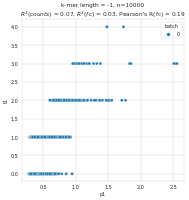

{'r2_counts': 0.0737645935408241,
 'r2_foldchange': 0.03433480654355259,
 'r2_enr': -0.052004336343208335,
 'r2_fc': 0.03482337571674615,
 'pearson_foldchange': 0.18661022404130528}

In [15]:
rcParams['figure.figsize'] = 6, 6
rcParams['figure.dpi'] = 35

mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1')


True
2
(76, 76)


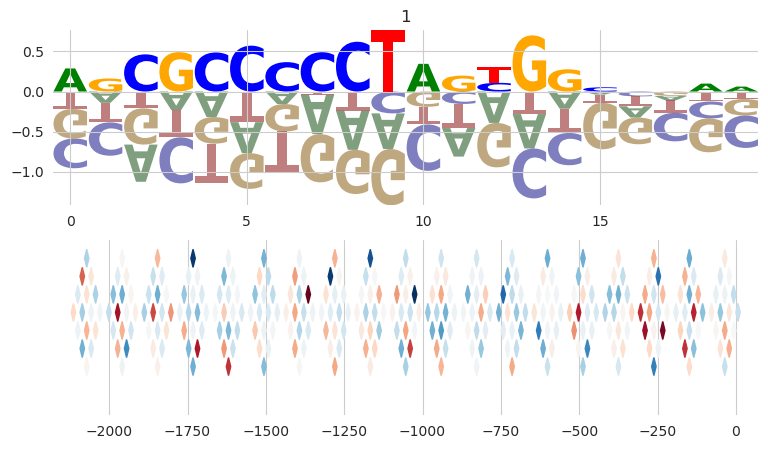

In [19]:
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 100
mb.pl.conv(model, n_cols=2)


In [21]:

model = model_by_k
mb.tl.scores(model, train)


{'r2_counts': 0.0737645935408241,
 'r2_foldchange': 0.03433480654355259,
 'r2_enr': -0.052004336343208335,
 'r2_fc': 0.03482337571674615,
 'pearson_foldchange': 0.18661022404130528}

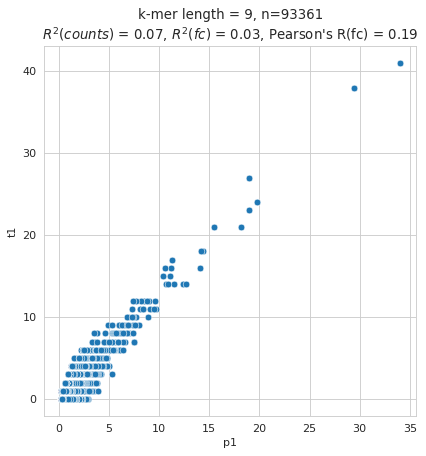

{'r2_counts': 0.0737645935408241,
 'r2_foldchange': 0.03433480654355259,
 'r2_enr': -0.052004336343208335,
 'r2_fc': 0.03482337571674615,
 'pearson_foldchange': 0.18661022404130528}

In [25]:
rcParams['figure.figsize'] = 6, 6
rcParams['figure.dpi'] = 80

mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=9)
